In [1]:
from typing import Callable

# Core dependencies
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

# pcax
import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

import torchvision
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

2024-05-27 02:07:53.675821: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# Model definition
class TwoLayerNN(pxc.EnergyModule):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, act_fn: Callable[[jax.Array], jax.Array]) -> None:
        super().__init__()
        self.act_fn = px.static(act_fn)
        self.layers = [
            pxnn.Linear(input_dim, hidden_dim),
            pxnn.Linear(hidden_dim, output_dim)
        ]

        # create a glorot uniform initializer:
        # see: https://pytorch.org/docs/2.0/nn.init.html?highlight=xavier#torch.nn.init.xavier_uniform_
        # see: https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.initializers.variance_scaling.html#jax.nn.initializers.variance_scaling
        #initializer = jax.nn.initializers.glorot_uniform() # this is wrong
        # relu adjust JAX scale value
        scale_ = 6.0
        initializer_ = jax.nn.initializers.variance_scaling(scale=scale_, mode='fan_avg', distribution='uniform')
        # more here: https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.initializers.variance_scaling.html#jax.nn.initializers.variance_scaling
        # now apply glorot uniform initialization to the weights only
        for l in self.layers:
            l.nn.weight.set(initializer_(px.RKG(), l.nn.weight.shape))
        
        self.vodes = [
            pxc.Vode((hidden_dim,)),
            pxc.Vode((output_dim,), pxc.ce_energy)
        ]
        self.vodes[-1].h.frozen = True

    @staticmethod
    def name():
        return "two_layer_nn"

    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            x = v(self.act_fn(l(x)))
        x = self.vodes[-1](self.layers[-1](x))
        if y is not None:
            self.vodes[-1].set("h", y)
        return self.vodes[-1].get("u")

In [3]:
Dataset = namedtuple("Dataset", ["train_loader", "val_loader", "test_loader"])

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=16,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )

# Function to add noise to the labels in the dataset
def add_label_noise(dataset, noise_level=0.2):
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    num_noisy = int(noise_level * len(targets))
    noisy_indices = np.random.choice(len(targets), num_noisy, replace=False)

    for idx in noisy_indices:
        original_label = targets[idx]
        new_label = original_label
        while new_label == original_label:
            new_label = np.random.randint(0, num_classes)
        targets[idx] = new_label

    dataset.targets = torch.tensor(targets)
    return dataset

# Function to get the dataloaders
def get_dataloaders(dataset_name, train_subset_size, batch_size, noise_level=0.2):
    if dataset_name.lower() == "mnist":
        ds = datasets.MNIST
    else:
        raise NotImplementedError(f"Dataset {dataset_name} isn't available")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(-1).numpy())  # Flatten the image to a vector
    ])

    train_set = ds(root='./data', download=True, train=True, transform=transform)
    train_set = add_label_noise(train_set, noise_level=noise_level)

    val_subset_size = int(0.2 * train_subset_size)
    random_train_indices = np.random.choice(len(train_set), size=train_subset_size, replace=False)
    remaining_indices = np.setdiff1d(np.arange(len(train_set)), random_train_indices)
    random_val_indices = np.random.choice(remaining_indices, size=val_subset_size, replace=False)

    train_loader = TorchDataloader(
        train_set, batch_size=batch_size, num_workers=16,
        sampler=torch.utils.data.sampler.SubsetRandomSampler(random_train_indices))
    val_loader = TorchDataloader(
        train_set, batch_size=batch_size, num_workers=16,
        sampler=torch.utils.data.sampler.SubsetRandomSampler(random_val_indices))

    test_set = ds(root='./data', download=True, train=False, transform=transform)
    test_loader = TorchDataloader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=16)

    return Dataset(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

In [4]:
# Training and evaluation functions
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: TwoLayerNN):
    return model(x, y)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: TwoLayerNN):
    y_ = model(x, None)
    return jax.lax.pmean(model.energy().sum(), "batch"), y_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, y: jax.Array, *, model: TwoLayerNN, optim_w: pxu.Optim, optim_h: pxu.Optim):
    model.train()
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            _, g = pxf.value_and_grad(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]), has_aux=True)(energy)(x, model=model)
        optim_h.step(model, g["model"], True)

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"])

@pxf.jit()
def eval_on_batch(x: jax.Array, y: jax.Array, *, model: TwoLayerNN):
    model.eval()
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        y_ = forward(x, jax.nn.one_hot(y, 10), model=model).argmax(axis=-1)
        e = model.vodes[-1].energy()
    return (y_ == y).mean(), y_, e.mean()

def train(dl, T, *, model: TwoLayerNN, optim_w: pxu.Optim, optim_h: pxu.Optim):
    for x, y in dl:
        #print(f"x shape: {x.shape}, y shape: {y.shape}")  # Debugging line
        train_on_batch(T, x, jax.nn.one_hot(y, 10), model=model, optim_w=optim_w, optim_h=optim_h)

def eval(dl, *, model: TwoLayerNN):
    acc = []
    es = []
    ys_ = []
    for x, y in dl:
        a, y_, e = eval_on_batch(x, y, model=model)
        acc.append(a)
        es.append(e)
        ys_.append(y_)
    return np.mean(acc), np.concatenate(ys_), np.mean(es)

In [5]:
# Model training and evaluation
nm_epochs = 50
batch_size = 128

model = TwoLayerNN(input_dim=784, hidden_dim=128, output_dim=10, act_fn=jax.nn.relu)

# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, 784)), None, model=model)
    optim_h = pxu.Optim(optax.sgd(0.1), pxu.Mask(pxc.VodeParam)(model))
    optim_w = pxu.Optim(optax.sgd(0.01, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))

# Assuming dataset is the namedtuple with the dataloaders
dataset = get_dataloaders("mnist", train_subset_size=4000, batch_size=batch_size, noise_level=0.0)
# Check the sizes of the datasets
print(f"Training set: {len(dataset.train_loader.sampler)} samples")
print(f"Validation set: {len(dataset.val_loader.sampler)} samples")
print(f"Test set: {len(dataset.test_loader.dataset)} samples")

Training set: 4000 samples
Validation set: 800 samples
Test set: 10000 samples


In [6]:
# Initialize lists to keep track of losses and accuracies
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# keep track of the train and test losses and accuracies for plotting purposes
for e in range(nm_epochs):
    # train the model
    train(dataset.train_loader, T=10, model=model, optim_w=optim_w, optim_h=optim_h)
    
    # evaluate the model and get accuracies and losses
    a_train, ys_train, e_train = eval(dataset.train_loader, model=model)
    a_val, ys_val, e_val = eval(dataset.val_loader, model=model)
    a_test, ys_test, e_test = eval(dataset.test_loader, model=model)

    # append losses and accuracies to lists
    train_losses.append(e_train)
    val_losses.append(e_val)
    test_losses.append(e_test)
    train_accuracies.append(a_train)
    val_accuracies.append(a_val)
    test_accuracies.append(a_test)

    # print accuracies
    print(f"Epoch {e + 1}/{nm_epochs} - Training Accuracy: {a_train * 100:.2f}% - Validation Accuracy: {a_val * 100:.2f}% - Test Accuracy: {a_test * 100:.2f}%")
    # print losses
    print(f"Epoch {e + 1}/{nm_epochs} - Training Loss: {e_train:.4f} - Validation Loss: {e_val:.4f} - Test Loss: {e_test:.4f}")

/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50 - Training Accuracy: 80.85% - Validation Accuracy: 79.43% - Test Accuracy: 80.54%
Epoch 1/50 - Training Loss: 1.0065 - Validation Loss: 0.9672 - Test Loss: 0.9917
Epoch 2/50 - Training Accuracy: 87.27% - Validation Accuracy: 84.24% - Test Accuracy: 85.47%
Epoch 2/50 - Training Loss: 0.5347 - Validation Loss: 0.6039 - Test Loss: 0.6591
Epoch 3/50 - Training Accuracy: 90.07% - Validation Accuracy: 86.33% - Test Accuracy: 87.61%
Epoch 3/50 - Training Loss: 0.3422 - Validation Loss: 0.4677 - Test Loss: 0.4990
Epoch 4/50 - Training Accuracy: 91.66% - Validation Accuracy: 88.02% - Test Accuracy: 88.29%
Epoch 4/50 - Training Loss: 0.2622 - Validation Loss: 0.4044 - Test Loss: 0.4641
Epoch 5/50 - Training Accuracy: 93.47% - Validation Accuracy: 87.63% - Test Accuracy: 89.21%
Epoch 5/50 - Training Loss: 0.2078 - Validation Loss: 0.4174 - Test Loss: 0.4277
Epoch 6/50 - Training Accuracy: 94.10% - Validation Accuracy: 88.54% - Test Accuracy: 89.35%
Epoch 6/50 - Training Loss: 0.1733 - 

In [7]:
# store/save the lists to a file for later use
np.savez("mnist_pc_results.npz", train_losses=train_losses, val_losses=val_losses, test_losses=test_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies, test_accuracies=test_accuracies)

In [8]:
# now reload the file and plot the results
results = np.load("mnist_pc_results.npz")
train_losses = results["train_losses"]
val_losses = results["val_losses"]
test_losses = results["test_losses"]
train_accuracies = results["train_accuracies"]
val_accuracies = results["val_accuracies"]
test_accuracies = results["test_accuracies"]

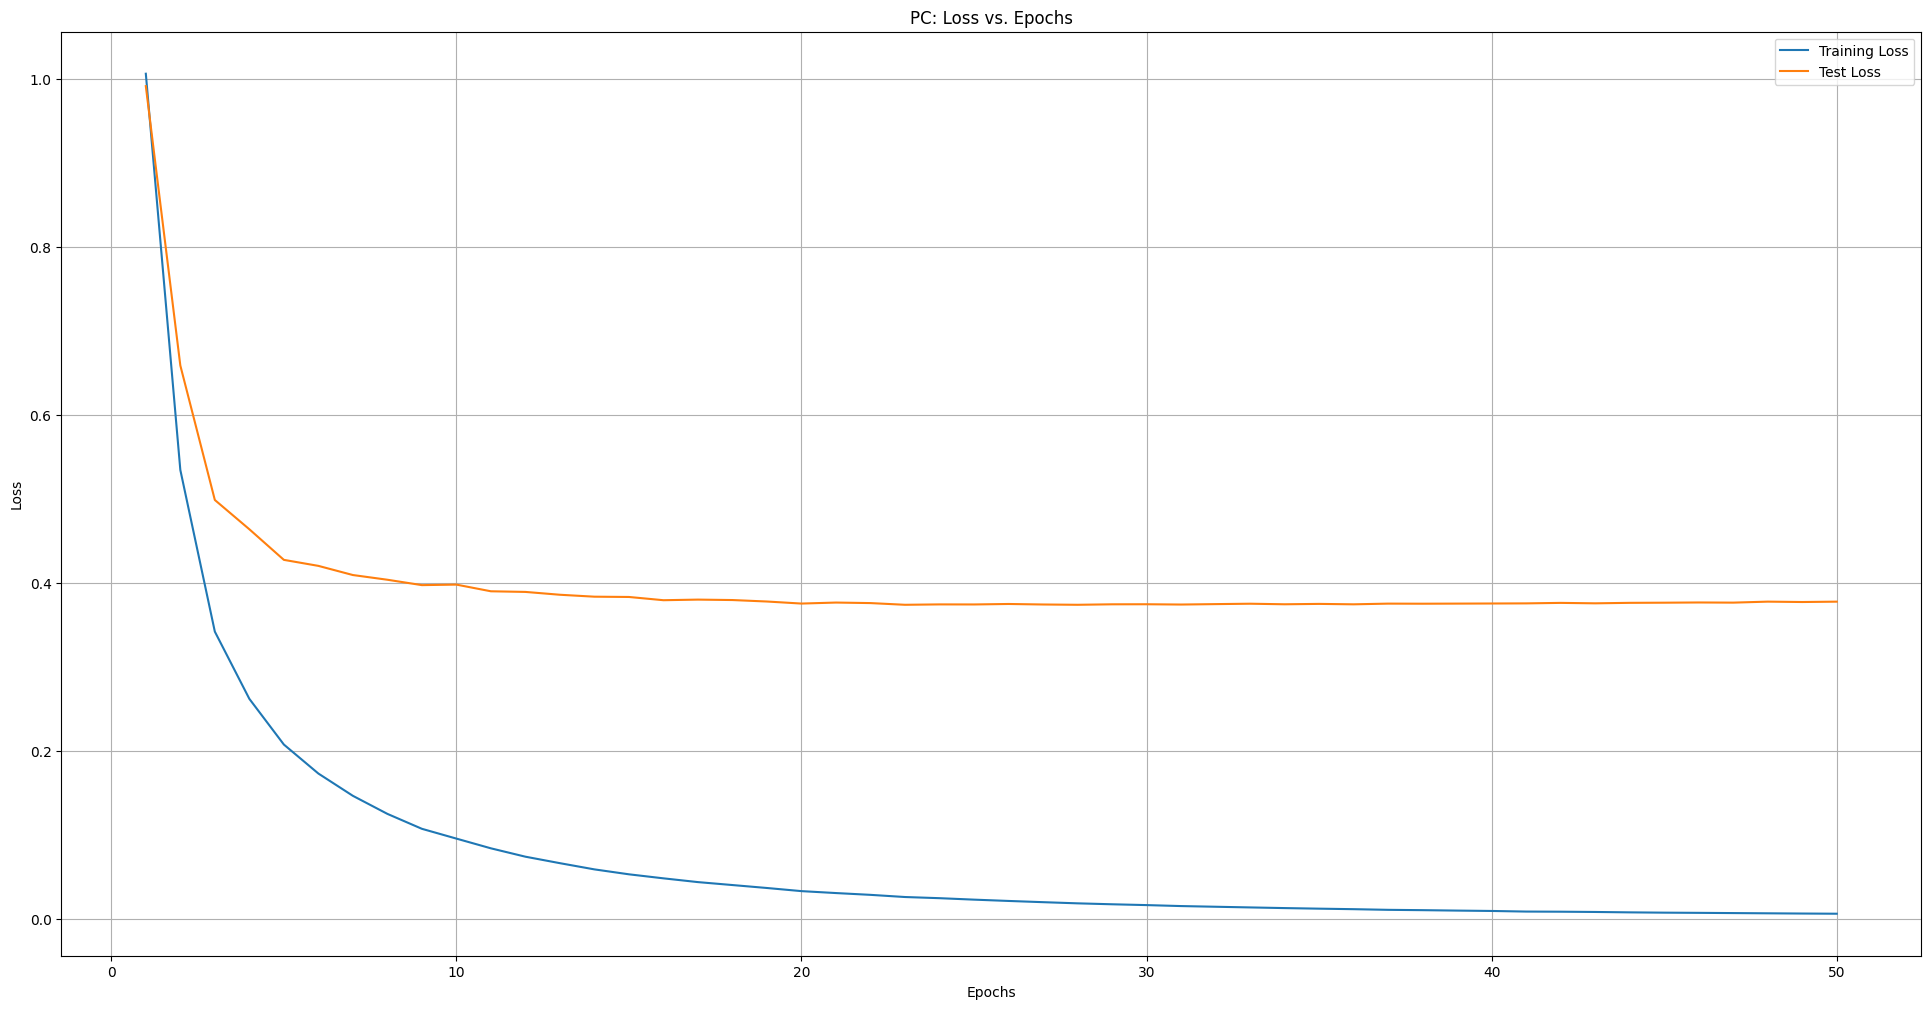

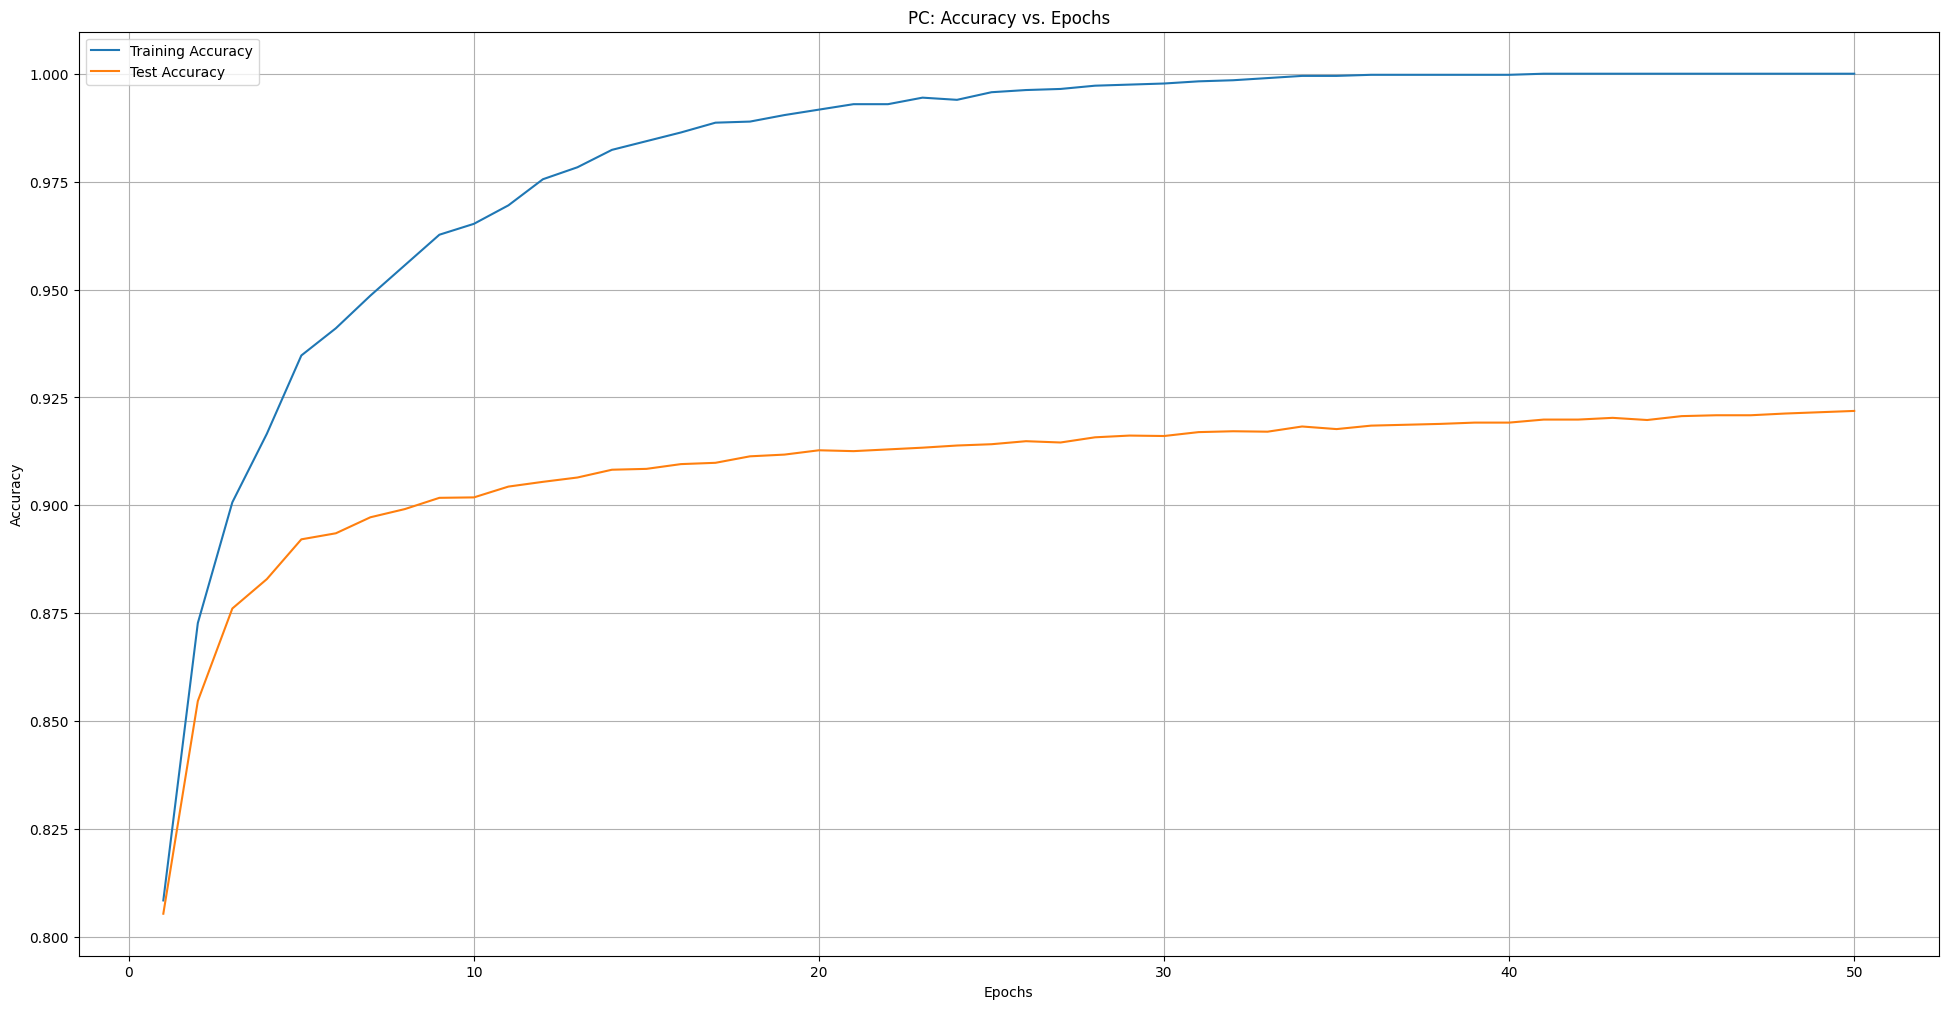

In [9]:
# Plotting the losses
nm_epochs = len(train_losses)
plt.figure(figsize=(24, 12))
plt.plot(range(1, nm_epochs + 1), train_losses, label='Training Loss')
#plt.plot(range(1, nm_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, nm_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PC: Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracies
plt.figure(figsize=(24, 12))
plt.plot(range(1, nm_epochs + 1), train_accuracies, label='Training Accuracy')
#plt.plot(range(1, nm_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, nm_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('PC: Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(model)

(TwoLayerNN):
  .layers[0].nn.weight: LayerParam([128,784], float32)
  .layers[0].nn.bias: LayerParam([128], float32)
  .layers[1].nn.weight: LayerParam([10,128], float32)
  .layers[1].nn.bias: LayerParam([10], float32)
  .vodes[0].h: VodeParam([128,128], float32)
  .vodes[0].cache: Cache(params=None)
  .vodes[1].h: VodeParam([128,10], float32)
  .vodes[1].cache: Cache(params=None)
